
## Sessions


A session is a contract between the user and the Qiskit Runtime service, making sure that a collection of jobs can be grouped and jointly prioritized by the quantum computer’s job scheduler. Jobs submitted within the session are not interrupted by other users’ jobs.

Sessions offer quite an advantage for algorithms needing iterative calls between classical and quantum, so that you don't lose time waiting in the queue at each step.



### Benefits of a session call

- Jobs that belong to a single algorithm run are run together without interruption, increasing efficiency if your program submits multiple sequential jobs.
    - The queuing time does not decrease for the first job submitted within a session. Therefore, a session does not provide any benefits if you only need to run a single job.
    - Since data from the first session job is cached and used by subsequent jobs, if the first job is cancelled, subsequent session jobs will all fail.
- When using sessions, the uncertainty around queuing time is significantly reduced. This allows better estimation of a workload’s total runtime and better resource management.
- In a device characterization context, being able to run experiments closely together helps prevent device drifts and provide more accurate results.
- As long as the session is active, you can submit different jobs, inspect job results, and re-submit new jobs without opening a new session.
- You maintain the flexibility to deploy your programs either remotely (cloud / on-premise) or locally (your laptop).

### The mechanics of a session

For each backend, the first job in the session waits its turn in the queue normally, but while the session is active, subsequent jobs within the same session take priority over any other queued jobs. If no jobs that are part of the active session are ready, the session is deactivated (paused), and the next job from the regular fair-share queue is run.


#### Batch execution

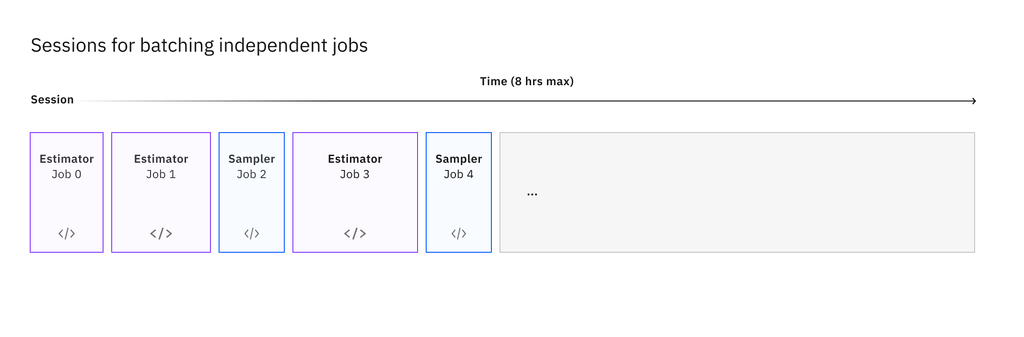

#### Iterative execution


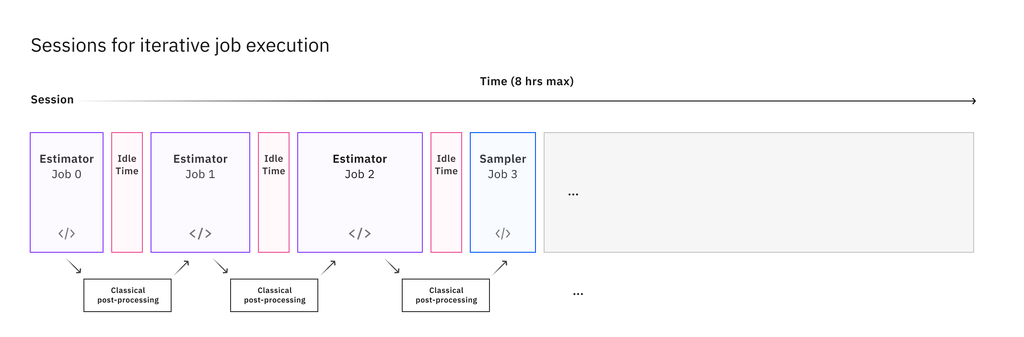

#### Batch execution

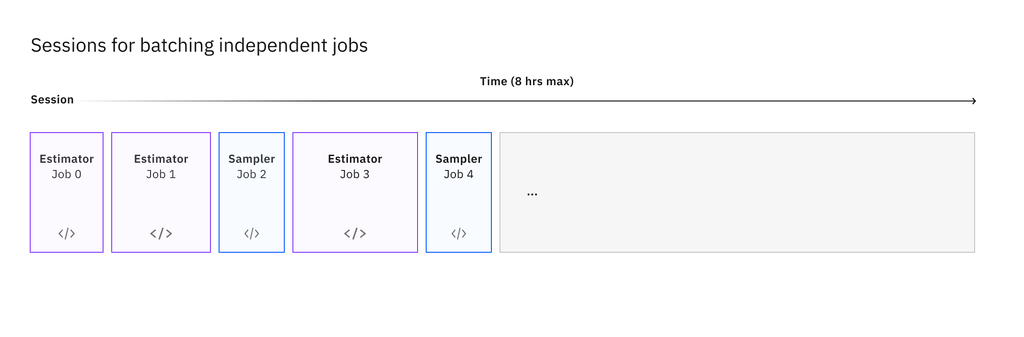

### How to use sessions with primitives

We'll only do the example with the Sampler, the Estimator works just the same.

The context manager will automatically open and close the session for you. You can do as many calls to primitives as you want as long as you don't go over the session's time limit.

The `max_time` is optional, it is the time your session will stay open.

In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator

service = QiskitRuntimeService(channel='ibm_quantum')
sim = service.backend('ibmq_qasm_simulator')
sampler = Sampler(backend = sim)

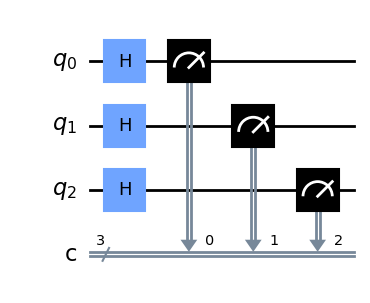

In [2]:
from qiskit import QuantumCircuit

circuit_shot = QuantumCircuit(3,3)
circuit_shot.h(0)
circuit_shot.h(1)
circuit_shot.h(2)
circuit_shot.measure([0,1,2],[0,1,2])
circuit_shot.draw('mpl')

In [3]:
from qiskit_ibm_runtime import Session, Options

options = Options(max_execution_time = 300)

with Session(backend = sim, max_time = 300) as session:
    
    sampler_1 = Sampler(options = options, session = session)
    shots_1 = 200
    result_1 = sampler_1.run(circuit_shot, shots = shots_1).result()
    print(f"Quasi-distribution with {shots_1} shots: {result_1.quasi_dists[0].binary_probabilities()}")
    
    # Now we repeat the same as above, but this time we increase the number of shots
    sampler_2 = Sampler(options = options, session = session)
    shots_2 = 2000
    result_2 = sampler_2.run(circuit_shot, shots = shots_2).result()
    print(f"Quasi-distribution with {shots_2} shots: {result_2.quasi_dists[0].binary_probabilities()}")

    session.close()

base_primitive._run_primitive:INFO:2023-11-20 10:33:06,717: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': 300, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 200, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


Traceback (most recent call last):
  Cell In[3], line 9
    result_1 = sampler_1.run(circuit_shot, shots = shots_1).result()
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/sampler.py:122 in run
    return super().run(
  File /opt/conda/lib/python3.10/site-packages/qiskit/primitives/base/base_sampler.py:147 in run
    return self._run(
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/sampler.py:152 in _run
    return self._run_primitive(
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/base_primitive.py:196 in _run_primitive
    return self._session.run(
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/session.py:39 in _wrapper
    return func(self, *args, **kwargs)
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/session.py:180 in run
    job = self._service.run(
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:1009 in run
    raise IBMRuntimeError(f"Failed 

In [ ]:
from qiskit.visualization import plot_distribution
legend = [f"{shots_1} shots", f"{shots_2} shots"]
plot_distribution([result_1.quasi_dists[0].binary_probabilities(), result_2.quasi_dists[0].binary_probabilities()], legend = legend)

## Options

The [Options](https://qiskit.org/ecosystem/ibm-runtime/stubs/qiskit_ibm_runtime.options.Options.html) class allows you to specify several parameters in the primitives. The two most commonly used ones are
- [optimization_level](https://qiskit.org/ecosystem/ibm-runtime/how_to/error-suppression.html) : for error suppression, it is the level of transpilation you wish to apply to your circuit. It is classical pre-processing to your overall runtime.
- [resilience_level](https://qiskit.org/ecosystem/ibm-runtime/how_to/error-mitigation.html) : for error mitigation, it allows mitigation of circuit errors by modeling the device noise at the time of execution. It results in quantum pre-processing overhead related to model training and classical post-processing overhead to mitigate errors in the raw results by using the generated model.

Depending on which primitive you use, techniques might be different. The `optimization_level` will be the exact same for both. As for the `resilience_level`, techniques and levels will vary between the two.

- Sampler
    - `optimization_level` : 0 to 3, default to 3
    - `resilience_level` : 0 to 1, default to 1

- Estimator
    - `optimization_level` : 0 to 3, default to 3
    - `resilience_level` : 0 to 3, default to 1




![options.png](attachment:options.png)

### A little more about error mitigation

[Error mitigation configuration tutorial.](https://qiskit.org/ecosystem/ibm-runtime/how_to/error-mitigation.html)

| Resilience level | Definition | Estimator | Sampler |
|--|--|--|--|
| 0 | No mitigation | None | None |
|1 (Default) | Minimal mitigation costs: Mitigate error associated with readout errors | Twirled Readout Error eXtinction (TREX) | M3|
|2 | Medium mitigation costs. Typically reduces bias in estimators, but is not guaranteed to be zero bias. | Zero Noise Extrapolation (ZNE) | — |
|3 | Heavy mitigation with layer sampling. Theoretically expected to deliver zero bias estimators. | Probabilistic Error Cancellation (PEC) | — |


- T-REx: [arXiv:2012.09738](https://arxiv.org/abs/2012.09738)
- ZNE: [arXiv:1612.02058](https://arxiv.org/abs/1612.02058)
- PEC: [arXiv:1612.02058](https://arxiv.org/abs/1612.02058)

#### Resilience level 0

No mitigation is applied at all when using the level 0.

#### Resilience level 1

- **Sampler** : Level 1 uses matrix-free measurement mitigation (M3) routine to mitigate readout error. M3 works in a reduced subspace defined by the noisy input bit strings that are to be corrected. Because the number of unique bit strings can be much smaller than the dimensionality of the full multi-qubit Hilbert space, the resulting linear system of equations is nominally much easier to solve.



- **Estimator** : Level 1 applies error mitigation methods that particularly address readout errors. In the Estimator, we apply a model-free technique known as Twirled Readout Error eXtinction (TREX). It reduces measurement error by diagonalizing the noise channel associated with measurement by randomly flipping qubits through X gates immediately before measurement, and flipping the corresponding measured bit if an X gate was applied. A rescaling term from the diagonal noise channel is learned by benchmarking random circuits initialized in the zero state. This allows the service to remove bias from expectation values that result from readout noise.


#### Resilience level 2

Level 2 uses the Zero Noise Extrapolation method (ZNE) which computes an expectation value of the observable for different noise factors (amplification stage) and then uses the measured expectation values to infer the ideal expectation value at the zero-noise limit (extrapolation stage). This approach tends to reduce errors in expectation values, but is not guaranteed to produce an unbiased result.

The overhead of this method scales with the number of noise factors. The default settings sample the expectation value at three noise factors, leading to a roughly 3x overhead when employing this resilience level.



#### Resilience level 3

Level 3 enables the Probabilistic Error Cancellation (PEC) method. This approach mitigates error by learning and inverting a sparse noise model that is able to capture correlated noise. PEC returns an unbiased estimate of an expectation value so long as learned noise model faithfully represents the actual noise model at the time of mitigation. In practice, the experimental procedure for learning the noise model has ambiguities due to certain error terms that cannot be independently distinguished. These are resolved by a symmetry assumption, which depending on the true underlying noise may lead a biased estimate of the mitigated expectation values due to using an imperfect noise model.



# Noisy simulation

Let's try to do a noisy simulation:

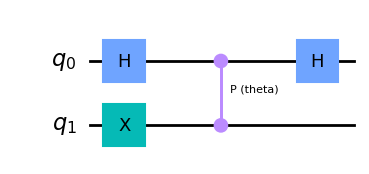

In [4]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

theta = Parameter('theta')

qc = QuantumCircuit(2)
qc.x(1)
qc.h(0)
qc.cp(theta,0,1)
qc.h(0)

qc.draw('mpl')

In [5]:
import numpy as np

phases = np.linspace(0, 2*np.pi, 50)
individual_phases = [[phase] for phase in phases] # phases need to be expressed as a list of lists in order to work

In [6]:
from qiskit.quantum_info import SparsePauliOp

ZZ = SparsePauliOp.from_list([("ZZ", 1)])

Here we won't do any error mitigation:

In [7]:
from qiskit.providers.fake_provider import FakeManila
from qiskit_aer.noise import NoiseModel

# Make a noise model
fake_backend = FakeManila()

noise_model = NoiseModel.from_backend(fake_backend)
basis_gates = fake_backend.configuration().basis_gates
coupling_map = fake_backend.configuration().coupling_map


# Set options to include the noise model
options = Options()
options.simulator = {
    "noise_model": noise_model,
    "basis_gates": basis_gates,
    "coupling_map": coupling_map,
    "seed_simulator": 42
}

# Set number of shots, optimization_level and resilience_level
options.execution.shots = 1000
options.optimization_level = 0
options.resilience_level = 0

And another option with error mitigation:

In [8]:
# Set options to include the noise model with error mitigation
options_with_em = Options()
options_with_em.simulator = {
    "noise_model": noise_model,
    "basis_gates": basis_gates,
    "coupling_map": coupling_map,
    "seed_simulator": 42
}

# Set number of shots, optimization_level, and resilience_level
options_with_em.execution.shots = 1000
options_with_em.optimization_level = 0 # no optimization
options_with_em.resilience_level = 1 # M3 for Sampler and T-REx for Estimator

In [9]:
with Session(service=service, backend=sim) as session:
    # include the noise model without T-REx
    estimator = Estimator(options = options, session = session)
    job = estimator.run(
        circuits = [qc]*len(phases),
        parameter_values = individual_phases,
        observables = [ZZ]*len(phases)
    )
    result = job.result()
    exp_values = result.values

    # include the noise model with T-REx
    estimator = Estimator(options = options_with_em, session = session)
    job = estimator.run(
        circuits = [qc]*len(phases),
        parameter_values = individual_phases,
        observables = [ZZ]*len(phases))
    result = job.result()
    exp_values_with_em = result.values
    session.close()

base_primitive._run_primitive:INFO:2023-11-20 10:36:32,610: Submitting job using options {'optimization_level': 0, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 0}, 'coupling_map': [[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3]], 'basis_gates': ['id', 'rz', 'sx', 'x', 'cx', 'reset']}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 1000, 'init_qubits': True, 'noise_model': <NoiseModel on ['id', 'x', 'sx', 'measure', 'cx', 'reset']>, 'seed_simulator': 42}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': <NoiseModel on ['id', 'x', 'sx', 'measure', 'cx', 'reset']>, 'basis_gates': ['id', 'rz', 'sx', 'x', 'cx', 'reset'], 'coupl

Traceback (most recent call last):
  Cell In[9], line 4
    job = estimator.run(
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/estimator.py:147 in run
    return super().run(
  File /opt/conda/lib/python3.10/site-packages/qiskit/primitives/base/base_estimator.py:188 in run
    return self._run(
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/estimator.py:185 in _run
    return self._run_primitive(
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/base_primitive.py:196 in _run_primitive
    return self._session.run(
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/session.py:39 in _wrapper
    return func(self, *args, **kwargs)
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/session.py:180 in run
    job = self._service.run(
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:1009 in run
    raise IBMRuntimeError(f"Failed to run program: {ex}") from None
IBMRu

In [ ]:
import matplotlib.pyplot as plt

plt.plot(phases, exp_values, 'o', label='Noisy')
plt.plot(phases, exp_values_with_em, 'o', label='Mitigated')
plt.plot(phases, 2*np.sin(phases/2)**2-1, label='Exact')
plt.xlabel('Phase')
plt.ylabel('Expectation')
plt.legend()